# Stereo Vision

Tasks:
1. Describe how to compute disparity between given pair of rectified images of the same image captured from two different viewpoints.
2. Computes the disparity of two images.
3. Apply the algorithm on the two provided images to derive their disparity maps. Discuss your observation.
4. Discuss what affects disparity map computation and any possible improvements to your developed algorithm. (optional)

References:
+ https://github.com/Z769018860/Simple-SSD-Stereo
+ https://github.com/2b-t/SciPy-stereo-sgm/blob/master/stereo_matching.py

## 0. Imports and Configurations

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
from dataclasses import dataclass, field # clean code
import cv2

%matplotlib inline

In [2]:
# Define constants
DATA_DIR = "..\data"
LEFT_EXT = "l.jpg"
RIGHT_EXT = "r.jpg"
SAMPLE_NAMES = ["corridor", "triclopsi2"]
OUTPUT_DIR = "..\out"

In [3]:
# Variables
img_idx = 1

## 1. Load Data

In [4]:
@dataclass
class StereoImage:
    name: str
    I_l: np.ndarray = field(repr=False)
    I_r: np.ndarray = field(repr=False)
    W: int = field(init=False)
    H: int = field(init=False)
    DMAP: np.ndarray = field(init=False, repr=False)
    
    def __post_init__(self):
        self.H, self.W = self.I_l.shape 
        self.I_l = self.I_l.astype('float32')
        self.I_r = self.I_r.astype('float32')
        self.DMAP = None
        
    def set_disparity_map(self, d_map):
        self.DMAP = d_map
        
    def show(self, save_path=None):
        subplot_value = 120
        if self.DMAP is not None:
            subplot_value = 130
        plt.figure(1, figsize=(20, 20))
        plt.subplot(subplot_value+1)
        plt.title(self.name + "_left")
        plt.tick_params(axis='both', which='major', labelsize=10, 
                        labelbottom = False, bottom=False, 
                        top = False, labeltop=True)
        plt.imshow(self.I_l, cmap='gray')
        
        plt.subplot(subplot_value+2)
        plt.title(self.name + "_right")
        plt.tick_params(axis='both', which='major', labelsize=10, 
                        labelbottom = False, bottom=False, 
                        top = False, labeltop=True)
        plt.imshow(self.I_r, cmap='gray')
        
        if self.DMAP is not None:
            plt.subplot(subplot_value+3)
            plt.title(self.name + "_DMAP")
            plt.tick_params(axis='both', which='major', labelsize=10, 
                            labelbottom = False, bottom=False, 
                            top = False, labeltop=True)
            plt.imshow(self.DMAP, cmap='gray')
        
        if save_path is not None:
            plt.savefig(save_path, dpi=160, bbox_inches='tight',pad_inches = 0)
        plt.show()
        

In [5]:
def load_stereo_images():
    global DATA_DIR
    global LEFT_EXT, RIGHT_EXT
    global SAMPLE_NAMES
    stereo_images = []
    for img_name in SAMPLE_NAMES:
        img_l_path = os.path.join(DATA_DIR, img_name + LEFT_EXT)
        try:
            img_l = cv2.imread(img_l_path, cv2.IMREAD_GRAYSCALE)
        except:
            print(f"fail to find left image at: {img_l_path}")
            continue
            
        img_r_path = os.path.join(DATA_DIR, img_name + RIGHT_EXT)
        try:
            img_r = cv2.imread(img_r_path, cv2.IMREAD_GRAYSCALE)
        except:
            print(f"fail to find right image at: {img_r_path}")
            continue
        assert img_l.shape == img_r.shape # check both images have same H, W
        stereo_images.append(StereoImage(img_name, img_l, img_r))
    return stereo_images

stereo_images = load_stereo_images()
print(f"Loaded {len(stereo_images)} images.")

Loaded 2 images.


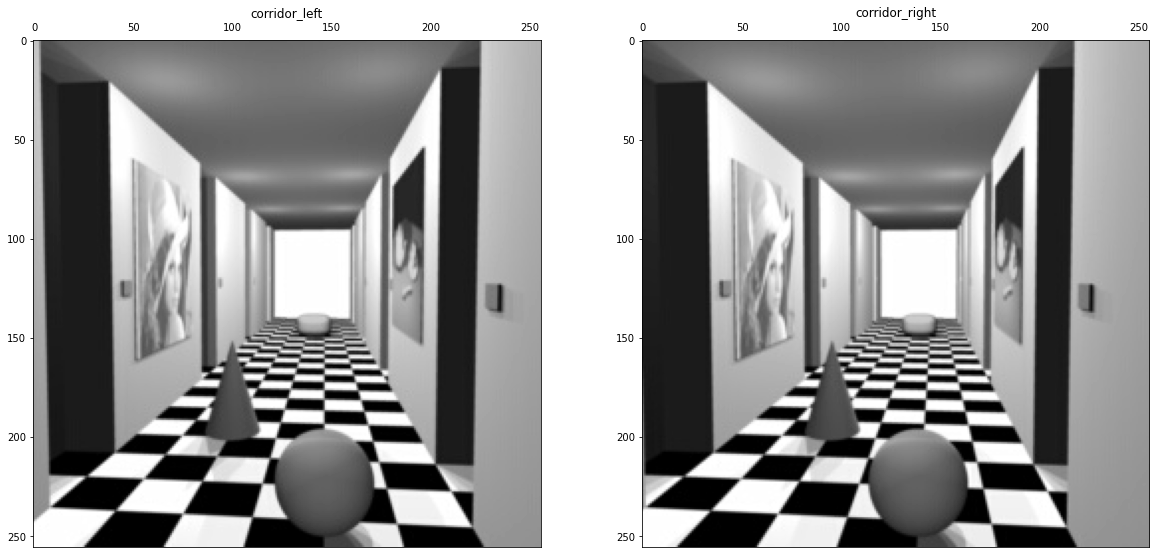

In [6]:
stereo_images[0].show(save_path=f"{stereo_images[0].name} pairs.jpg")

In [7]:
print(stereo_images[1])

StereoImage(name='triclopsi2', W=320, H=240)


In [8]:
def compute_matching_cost_window(S: StereoImage, 
                          D: int, m: int, algo='ssd'):
    """
    This function computes the matching cost between the stereo images.

    Args:
        S (StereoImage): data class containing left and right image arrays
        D (int): max number of disparities
        m (int): window size
        algo (str): choose either 'ssd' or 'sad'
    
    Returns:
        cost (np.ndarray): cost volume of size (H,W,D)
    """
    assert algo == 'ssd' or algo == 'sad'
    
    cost = np.zeros((S.H, S.W, D))
    m_2 = m//2 
    
    # move to pixel location
    for y in range(m_2, S.H - m_2):
        for x in range(m_2, S.W - m_2):
            # window (m x m)
            for v in range(-m_2, m_2 + 1):
                for u in range(-m_2, m_2 + 1):
                    w_l = S.I_l[y+v,x+u]   
                    # disparities range
                    for d in range(D):         
                        w_r = S.I_r[y+v,x+u-d]
                        if algo == 'ssd':
                            cost[y,x,d] += (w_l - w_r)**2
                        elif algo == 'sad':
                            cost[y,x,d] += np.abs(w_l - w_r)

    return cost

def cost_aggregation_avg(cost:np.ndarray, f:int=3):
    """
    This function takes the average of all the disparities 
    under kernel area and replaces the central element with the average
    
    Args:
        cost: matching cost volume
        f (int): kernel size for averaging
        
    Returns: 
        agg_cost (np.ndarray): agg cost volume of size (H,W,D)
    """
    agg_cost = np.zeros(cost.shape)    
    D = cost.shape[2]
    for d in range(D): 
        agg_cost[:,:,d] = cv2.blur(cost[:,:,d],(f,f))
    
    return agg_cost

def disparity_selection_wta(cost: np.ndarray):
    """
    Implement WTA strategy:
    Select the minimum disparity value for each pixel
    
    Args:
        cost (np.ndarray): 3D array (h, w, d)
        
    Returns:
        dmap (np.ndarray): 2D array (h, w)
    """
    return np.argmin(cost, axis=2)

def disparity_refinement_smooth(dmap: np.ndarray, f=3):
    """
    Performs disparity map smoothing:
    
    Args:
        dmap (np.ndarray): disparity map
        f (int): kernel size for averaging
        
    Returns: 
        dmap (np.ndarray): smoothed disparity map
    """
    return cv2.blur(dmap,(f,f)) 

# def disparity_refinement_median_filter(dmap: np.ndarray):
#     refined_dmap = cv2_filter.weightedMedianFilter(Il.astype('uint8'),Ll.astype('uint8'),15,5,cv2_x.WMF_JAC)

def show_disparity_map(S: StereoImage, save_path=None):
    plt.figure(0, figsize=(7, 7))
    plt.title(S.name + "_DMAP")
    plt.tick_params(axis='both', which='major', labelsize=10, 
                        labelbottom = False, bottom=False, 
                        top = False, labeltop=True)
    plt.imshow(S.DMAP, cmap='gray')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()
    
def window_based_disparity(S: StereoImage, D: int, m: int, algo='ssd',
                          agg_filter=5, ref_filter=3, plot=True, save_dir=None):
    """
    Implements the window-based disparity computing of two stereo images.
    
    Args:
        S (StereoImage): data class containing left and right image arrays
        D (int): max number of disparities
        m (int): window size
        algo (str): choose either 'ssd' or 'sad'
        agg_filter (int): aggregation filter size
        ref_filter (int): refinement filter size
        plot (bool): show disparity map
        save_path (str): save directory, set None to not save
        
    Returns:
        S (StereoImage): object with updated disparity map
    """
    cost = compute_matching_cost_window(S, D=D, m=m, algo=algo)
    if agg_filter > 0: cost = cost_aggregation_avg(cost, f=agg_filter)
    d_map = disparity_selection_wta(cost)
    if ref_filter > 0: d_map = disparity_refinement_smooth(d_map, f=ref_filter)
    S.set_disparity_map(d_map)
    if plot: 
        save_path = save_dir
        if save_dir is not None:
            save_path = os.path.join(save_dir, 
                 f"DMAP_{S.name}_D={D}_m={m}_{algo}_af={agg_filter}_rf={ref_filter}.jpg")
            print(save_path)
        S.show(save_path=save_path)
    return S

..\out\DMAP_corridor_D=16_m=7_ssd_af=3_rf=1.jpg


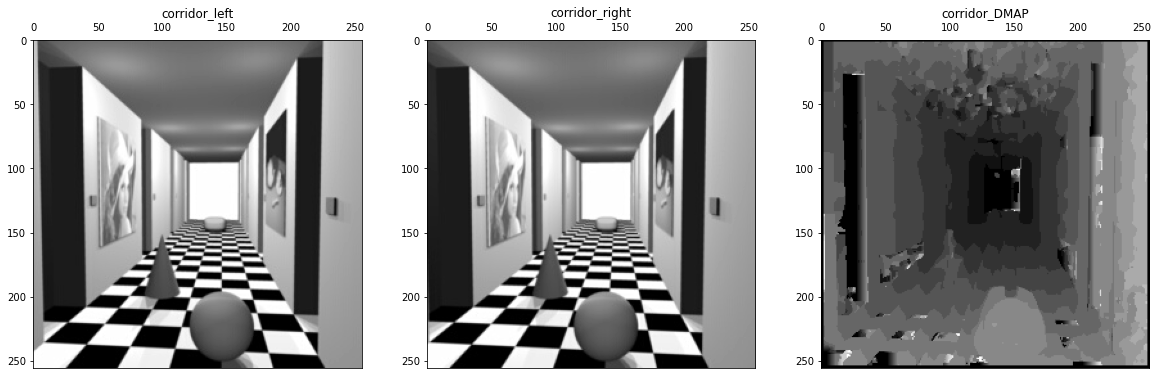

>>> Time taken: 155.967871 sec.


In [9]:
start = time.time()
window_based_disparity(stereo_images[0], D=16, m=7,algo='ssd',
                       agg_filter=3, ref_filter=1, plot=True, save_dir=OUTPUT_DIR)
end = time.time()
print('>>> Time taken: %f sec.' % (end - start))

..\out\DMAP_triclopsi2_D=20_m=9_ssd_af=3_rf=1.jpg


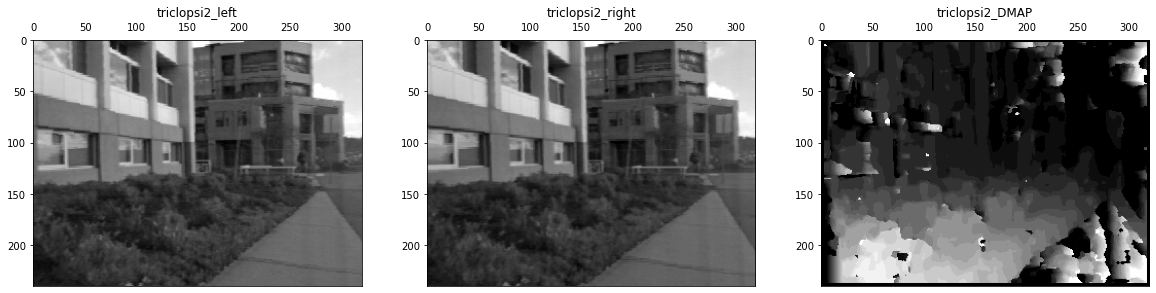

>>> Time taken: 383.132406 sec.


In [10]:
start = time.time()
window_based_disparity(stereo_images[1], D=20, m=9,algo='ssd',
                       agg_filter=3, ref_filter=1, plot=True, save_dir=OUTPUT_DIR)
end = time.time()
print('>>> Time taken: %f sec.' % (end - start))

..\out\DMAP_triclopsi2_D=20_m=7_ssd_af=1_rf=1.jpg


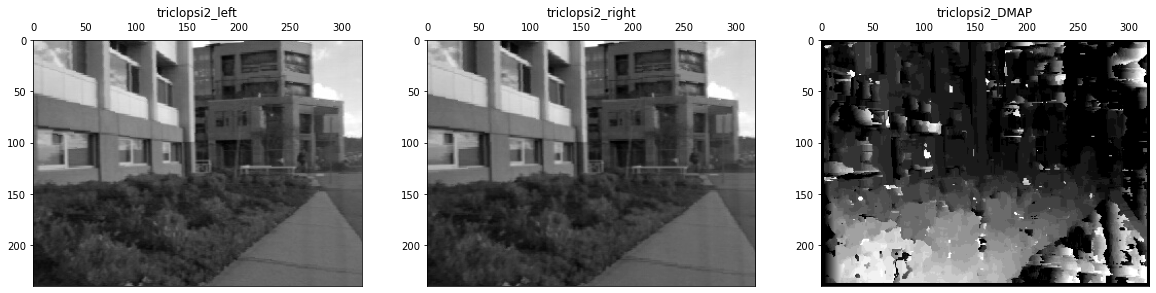

>>> Time taken: 216.024479 sec.


In [11]:
start = time.time()
window_based_disparity(stereo_images[1], D=20, m=7,algo='ssd',
                       agg_filter=1, ref_filter=1, plot=True, save_dir=OUTPUT_DIR)
end = time.time()
print('>>> Time taken: %f sec.' % (end - start))

..\out\DMAP_triclopsi2_D=20_m=9_ssd_af=1_rf=1.jpg


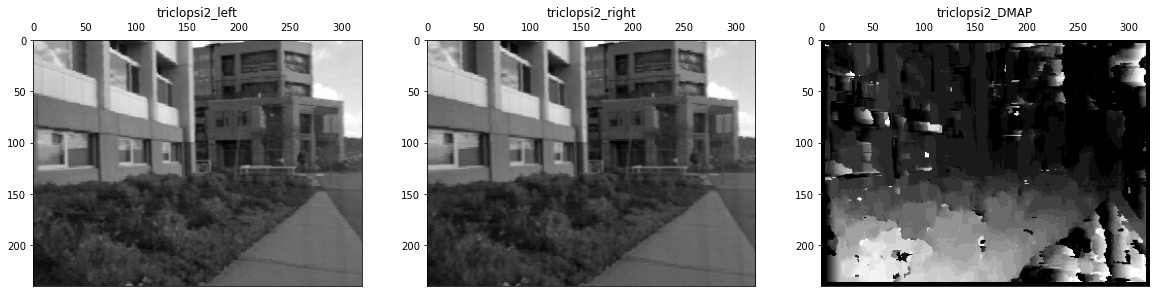

>>> Time taken: 345.511627 sec.


In [12]:
start = time.time()
window_based_disparity(stereo_images[1], D=20, m=9,algo='ssd',
                       agg_filter=1, ref_filter=1, plot=True, save_dir=OUTPUT_DIR)
end = time.time()
print('>>> Time taken: %f sec.' % (end - start))

In [13]:
d_values = [20] #16, 20
m_values = [9]
agg_filters = [3]
ref_filter = [1]
algo = 'ssd'

img_d_maps = []
s_i =stereo_images[1]
# for s_i in stereo_images:
d_maps = []
for dv in d_values:
    for mv in m_values:
        cost = compute_matching_cost_window(s_i, D=dv, m=mv)
        for af in agg_filters:
            if af > 0: 
                cost = cost_aggregation_avg(cost, f=af)
            d_map = disparity_selection_wta(cost)    
            for rf in ref_filter:
                if rf > 0: 
                    d_map = disparity_refinement_smooth(d_map, f=rf)

                file_name = f"D={dv}_m={mv}_{algo}_af={af}_rf={rf}"
                d_maps.append((file_name, d_map))
img_d_maps.append((s_i.name, d_maps))

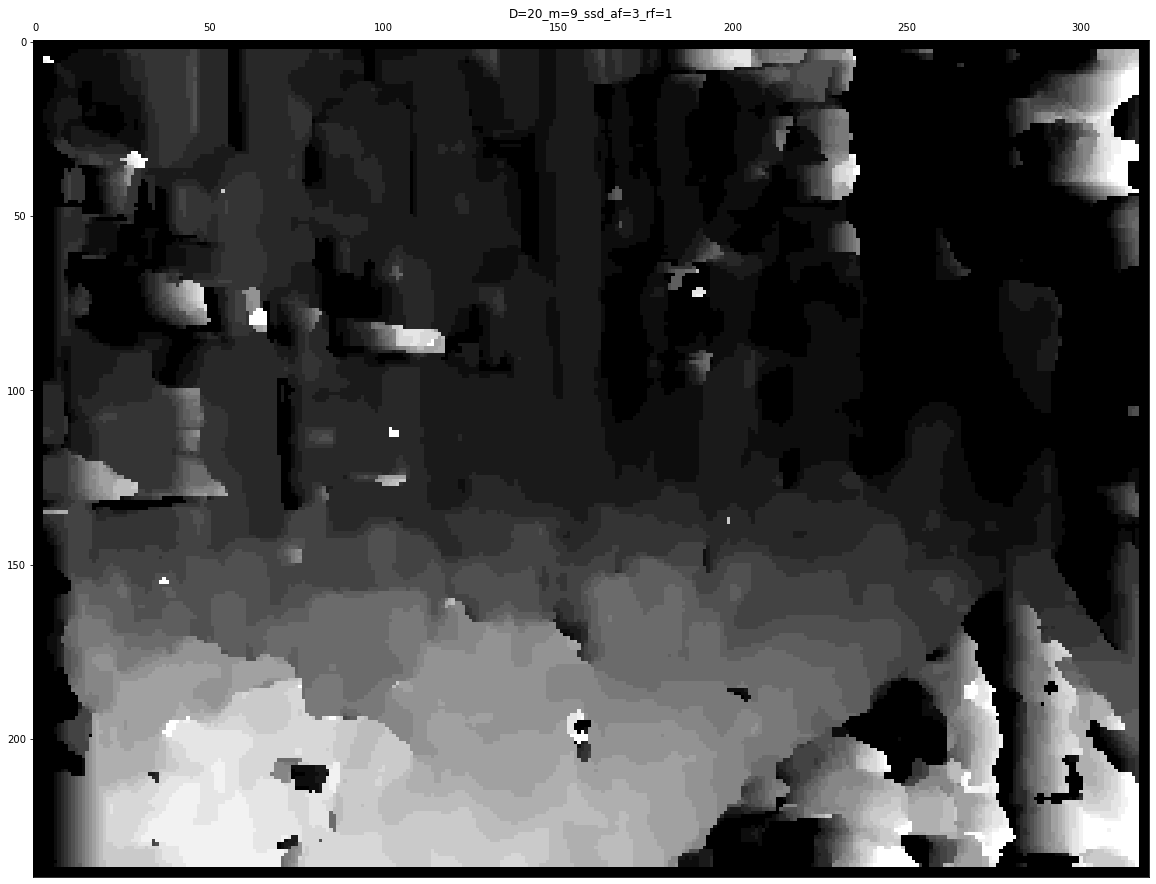

In [14]:
for img_name, img_maps in img_d_maps:
    plt.figure(1, figsize=(20, 20))
    for idx, d_maps in enumerate(img_maps):
        subplot_number = 100 + 10*len(img_maps) + idx+1
        plt.subplot(subplot_number)
        plt.title(d_maps[0])
        plt.tick_params(axis='both', which='major', labelsize=10, 
                        labelbottom = False, bottom=False, 
                        top = False, labeltop=True)
        plt.imshow(d_maps[1], cmap='gray')
#     save_path = os.path.join(OUTPUT_DIR, f"rf_VAR_{img_name}.jpg")
    save_path = os.path.join(OUTPUT_DIR, f"DMAP_{d_maps[0]}_{img_name}.jpg")
    plt.savefig(save_path, dpi=160, bbox_inches='tight',pad_inches = 0)
    plt.show()

d_values = [8] #16, 20
m_values = [5, 7, 9]
agg_filters = [0, 1, 2]
ref_filter = [0, 1, 2]
algo = 'ssd'

for s_i in stereo_images:
    for dv in d_values:
        for mv in m_values:
            cost = compute_matching_cost_window(S, D=dv, m=mv)
            for af in agg_filters:
                if af > 0: 
                    cost = cost_aggregation_avg(cost, f=af)
                d_map = disparity_selection_wta(cost)    
                for rf in ref_filter:
                    if rf > 0: 
                        d_map = disparity_refinement_smooth(d_map, f=rf)
                    s_i.set_disparity_map(d_map)
                    save_path = os.path.join(OUTPUT_DIR, f"DMAP_{s_i.name}_D={dv}_m={mv}_{algo}_af={af}_rf={rf}.jpg")
                    print(save_path)
                    show_disparity_map(s_i, save_path=save_path)